<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/shrink-model/mask-or-not/mask_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mask or Not

Trains a Neural Network Classifier to predict whether a face image is wearing a mask or not.

Converts the Neural Network Classifier into a Tensorflow-Lite model for deployment to an embedded device (such as an Arduino).

In [50]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import pickle

In [51]:
!wget -q https://github.com/lisaong/stackup-workshops/raw/master/mask-or-not/data.zip -O data.zip
!unzip -o data.zip

Archive:  data.zip
  inflating: data/mask/1.jpg         
  inflating: data/mask/10.jpg        
  inflating: data/mask/2.jpg         
  inflating: data/mask/3.jpg         
  inflating: data/mask/4.jpg         
  inflating: data/mask/5.jpg         
  inflating: data/mask/6.jpg         
  inflating: data/mask/7.jpg         
  inflating: data/mask/8.jpg         
  inflating: data/mask/9.jpg         
  inflating: data/no_mask/1.jpg      
  inflating: data/no_mask/10.jpg     
  inflating: data/no_mask/2.jpg      
  inflating: data/no_mask/3.jpg      
  inflating: data/no_mask/4.jpg      
  inflating: data/no_mask/5.jpg      
  inflating: data/no_mask/6.jpg      
  inflating: data/no_mask/7.jpg      
  inflating: data/no_mask/8.jpg      
  inflating: data/no_mask/9.jpg      


In [52]:
# https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')

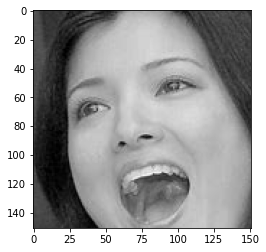

In [53]:
def detect(detector, path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(img)

  for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    plt.imshow(face, cmap='gray')
    plt.show()
  
detect(face_cascade, './data/no_mask/1.jpg')

In [54]:
detect(face_cascade, './data/mask/1.jpg')

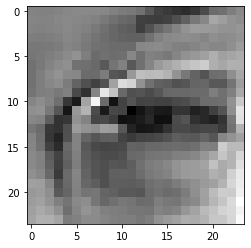

In [55]:
detect(eye_cascade, './data/mask/1.jpg')

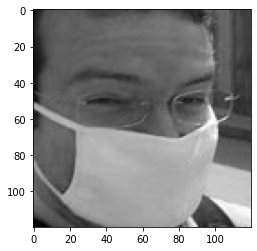

In [56]:
def crop_face(detector, eye_detector, path, output_size=(120, 120)):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width, channels = img.shape

  # use the colour version for detection, but the
  # grayscale version for result
  faces = detector.detectMultiScale(img)
  eyes = eye_detector.detectMultiScale(img)

  face = None
  if len(faces) > 0:
    x,y,w,h = faces[0]
    face = gray[y:y+h, x:x+w]
  elif len(eyes) > 0:
    # mask is stumping haar face detection
    # approximate face by detecting the left eye
    x,y,w,h = eyes[0]
    # approximate face dimensions using the
    # left eye as reference
    face = gray[max(0, y-2*h):min(y+4*h, height), 
                max(0, x-3*w):min(x+2*w, width)]
  else:
    # nothing detected, just return original image
    face = gray

  face = cv2.resize(face, output_size)
  plt.imshow(face, cmap='gray')
  plt.show()
  return face

crop_face(face_cascade, eye_cascade, './data/mask/1.jpg');

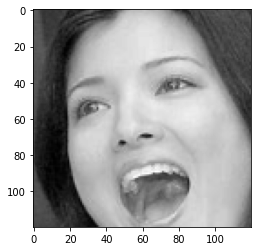

In [57]:
crop_face(face_cascade, eye_cascade, './data/no_mask/1.jpg');

1.jpg


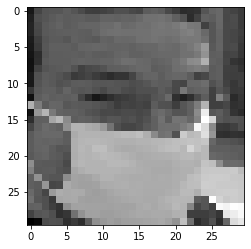

9.jpg


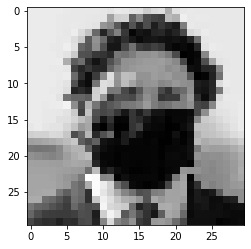

8.jpg


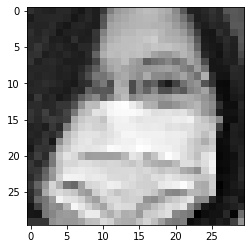

5.jpg


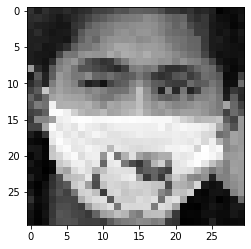

6.jpg


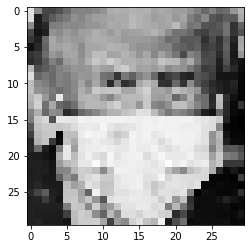

10.jpg


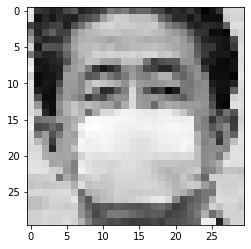

7.jpg


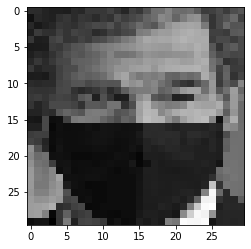

3.jpg


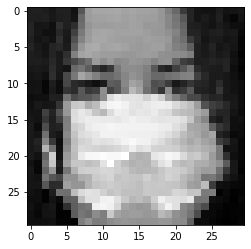

4.jpg


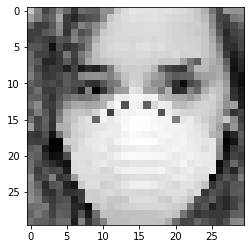

2.jpg


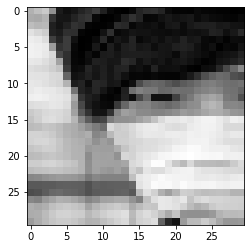

(10, 30, 30)

In [58]:
def get_image_data(label):
  images = []
  for path in Path(f'./data/{label}').rglob('*.jpg'):
    print(path.name)
    images.append(np.array(crop_face(face_cascade, eye_cascade, 
                                     f'./data/{label}/{path.name}', 
                                     output_size=(30, 30))))
  return np.array(images)

images_mask = get_image_data('mask')
images_mask.shape

1.jpg


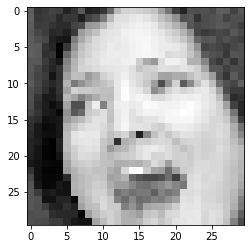

9.jpg


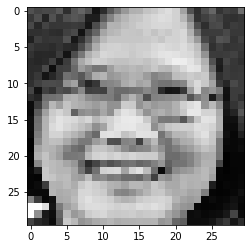

8.jpg


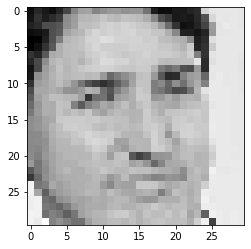

5.jpg


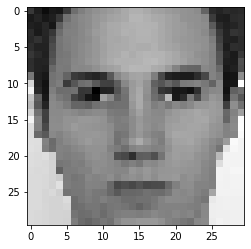

6.jpg


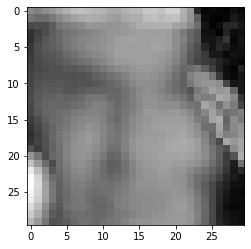

10.jpg


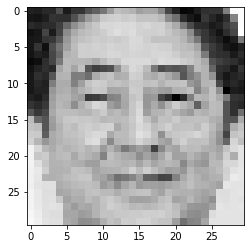

7.jpg


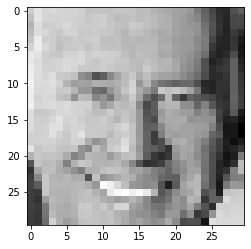

3.jpg


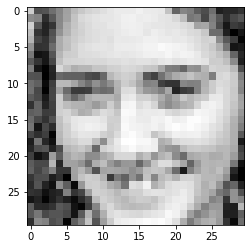

4.jpg


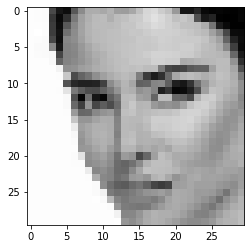

2.jpg


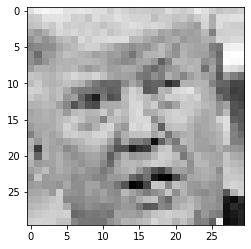

(10, 30, 30)

In [59]:
images_nomask = get_image_data('no_mask')
images_nomask.shape

In [60]:
labels = ['nomask'] * images_nomask.shape[0] + ['mask'] * images_mask.shape[0]
labels

['nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [61]:
images = np.vstack([images_nomask, images_mask])
images.shape

(20, 30, 30)

In [62]:
# flatten
X = images.reshape(-1, images.shape[1]*images.shape[2])
X.shape

(20, 900)

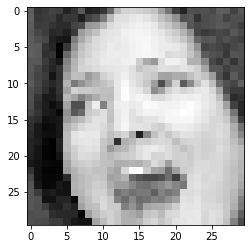

In [63]:
# can we get it back?
plt.imshow(X[0].reshape(images.shape[1], images.shape[2]), cmap='gray')
plt.show()

In [64]:
pca = PCA(n_components=.95)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# tune PCA
pca.fit(X_scaled)

pca.explained_variance_ratio_

array([0.23782727, 0.16341577, 0.14535538, 0.09474524, 0.05498984,
       0.05423754, 0.03297292, 0.03095714, 0.02893787, 0.02430133,
       0.0224027 , 0.01930378, 0.01756646, 0.01665538, 0.01422465])

In [65]:
np.arange(1, pca.n_components_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

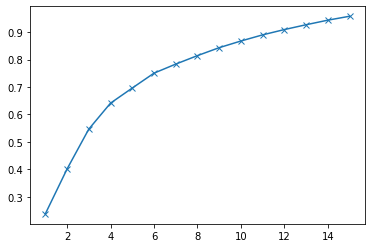

In [66]:
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.show()

In [67]:
# choose 5 features, since we only have 20 rows
pca = PCA(n_components=5)
Z = pca.fit_transform(X_scaled)

In [68]:
# let's do a pairplot
df = pd.DataFrame(Z)
df['label'] = labels
df.head()

,0,1,2,3,4,label
0,-7.368699,-5.451864,-12.075984,-5.300018,1.238091,nomask
1,-9.513286,-3.283724,-8.629328,5.165741,-12.834429,nomask
2,-0.175953,14.224692,-1.681378,-6.640212,6.079975,nomask
3,7.471832,3.593096,-2.580619,-12.037405,1.470550,nomask
4,12.848992,-14.443459,-1.945471,-0.347205,-0.892431,nomask


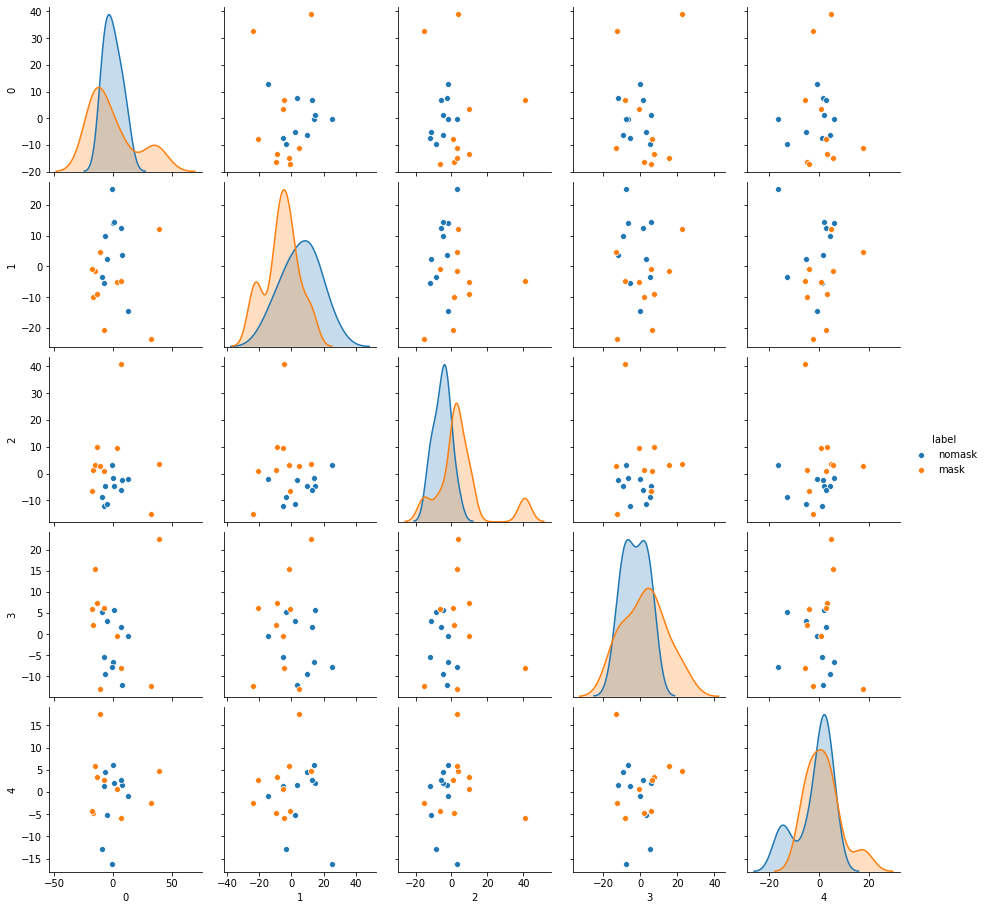

In [69]:
sns.pairplot(df, hue='label')

In [70]:
le = LabelEncoder()
y = le.fit_transform(labels)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, random_state=42, stratify=y)

In [72]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8

In [73]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



## Neural Networks

In [74]:
from tensorflow.keras import layers

mlp = tf.keras.Sequential()
mlp.add(layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
mlp.add(layers.Dense(X_train.shape[1], activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [75]:
mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train, batch_size=5, epochs=100,
                  validation_data=(X_test, y_test))

Epoch 1/100
3/3 [==============================] - 0s 49ms/step - loss: 5.6252 - accuracy: 0.4000 - val_loss: 2.4649 - val_accuracy: 0.4000
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 5.5426 - accuracy: 0.4000 - val_loss: 2.4398 - val_accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 5.4758 - accuracy: 0.4000 - val_loss: 2.4143 - val_accuracy: 0.4000
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 5.3907 - accuracy: 0.4000 - val_loss: 2.3892 - val_accuracy: 0.4000
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 5.3090 - accuracy: 0.4000 - val_loss: 2.3653 - val_accuracy: 0.4000
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 5.2563 - accuracy: 0.4000 - val_loss: 2.3391 - val_accuracy: 0.4000
Epoch 7/100
3/3 [==============================] - 0s 20ms/step - loss: 5.1600 - accuracy: 0.4000 - val_loss: 2.3156 - val_accuracy: 0.4000
Epoch 8/100
3/3 [===

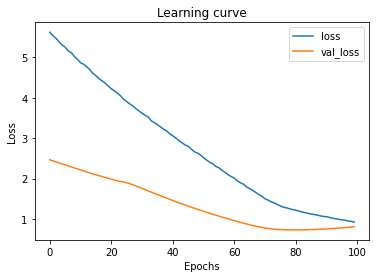

In [76]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [77]:
mlp.save('mlp.h5')

In [78]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [79]:
y_pred_mlp = mlp.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



In [80]:
# try without PCA, because NN can do dimensionality reduction automatically
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

mlp_full = tf.keras.Sequential()
mlp_full.add(layers.Dense(5, input_shape=(X_train.shape[1],), activation='relu'))
mlp_full.add(layers.Dense(1, activation='sigmoid'))
mlp_full.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 5)                 4505      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 6         
Total params: 4,511
Trainable params: 4,511
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
3/3 [==============================] - 0s 41ms/step - loss: 0.8334 - accuracy: 0.6000 - val_loss: 0.6599 - val_accuracy: 0.4000
Epoch 2/50
3/3 [==============================] - 0s 14ms/step - loss: 0.4782 - accuracy: 0.7333 - val_loss: 0.6567 - val_accuracy: 0.4000
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 0.3016 - accuracy: 0.9333 - val_loss: 0.6539 - val_accuracy: 0.4000
Epoch 4/50
3/3 [==============================] - 0s 13ms/step - loss: 0.2329 - accuracy: 0.9333 - val_loss: 0.6486 - val_accuracy: 0.4000
Epoch 5/50
3/3 [==============================] - 0s 13ms/step - loss: 0.1944 - accuracy: 0.9333 - val_loss: 0.6342 - val_accuracy: 0.6000
Epoch 6/50
3/3 [==============================] - 0s 16ms/step - loss: 0.1631 - accuracy: 1.0000 - val_loss: 0.6158 - val_accuracy: 0.6000
Epoch 7/50
3/3 [==============================] - 0s 14ms/step - loss: 0.1455 - accuracy: 1.0000 - val_loss: 0.6007 - val_accuracy: 0.6000
Epoch 8/50
3/3 [===========

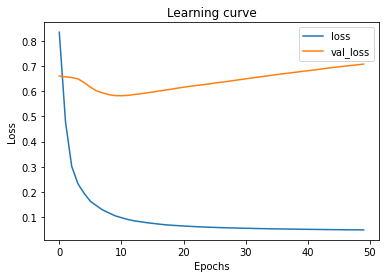

In [81]:
mlp_full.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp_full.fit(X_train, y_train, batch_size=5, epochs=50,
                      validation_data=(X_test, y_test))
mlp_full.save('mlp_full.h5')

# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [82]:
y_pred_mlp = mlp_full.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



Quantization to TFLite

https://www.tensorflow.org/lite/microcontrollers/build_convert

In [83]:
converter = tf.lite.TFLiteConverter.from_keras_model(mlp_full)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open('mlp_full.tflite', 'wb').write(tflite_model)

5720

In [84]:
# Test model loading
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='mlp_full.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

y_pred_tflite = []

# Test model on input data.
# Loop through each row of test_data and perform inference
for i in range(X_test.shape[0]):

  # add batch dimension
  input_data = np.expand_dims(X_test[i], axis=0).astype('float32')
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  y_pred_tflite.append(output_data[0][0])

print(classification_report(y_test, np.array(y_pred_tflite) >= 0.5))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [85]:
!pip install tinymlgen

In [86]:
# https://github.com/eloquentarduino/tinymlgen
import tinymlgen

c_code = tinymlgen.port(mlp_full)
with open('mlp_full.h', 'w') as f:
  f.write(c_code)

print(c_code)


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x0c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00, 0x96, 0xed, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x14, 0x16, 0x00, 0x00, 0x54, 0x12, 0x00, 0x00, 0x3c, 0x12, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x09, 0x00, 0x00, 0x00, 0x2c, 0x12, 0x00, 0x00, 0x24, 0x12, 0x00, 0x00, 0x00, 0x12, 0x00, 0x00, 0xe4, 0x11, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x4c, 0xea, 0xff, 0xff, 0x50, 0xea, 0xff, 0xff, 0x54, 0xea, 0xff, 0xff, 0x2e, 0xee, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x95, 0x72, 0x3d, 0x3e, 0x8b, 0x8e, 0x78, 0x3f, 0x34, 0xcb,

In [87]:
with open('mlp_full.h', 'r') as f:
  print(f.read())


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x0c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00, 0x96, 0xed, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x14, 0x16, 0x00, 0x00, 0x54, 0x12, 0x00, 0x00, 0x3c, 0x12, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x09, 0x00, 0x00, 0x00, 0x2c, 0x12, 0x00, 0x00, 0x24, 0x12, 0x00, 0x00, 0x00, 0x12, 0x00, 0x00, 0xe4, 0x11, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x4c, 0xea, 0xff, 0xff, 0x50, 0xea, 0xff, 0xff, 0x54, 0xea, 0xff, 0xff, 0x2e, 0xee, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x95, 0x72, 0x3d, 0x3e, 0x8b, 0x8e, 0x78, 0x3f, 0x34, 0xcb,

In [88]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'X' : X,
    'y' : y,
    'X_scaler' : scaler,
    'X_pca' : pca,
    'y_encoder' : le,
    'lr' : lr,
    'mlp_filename' : 'mlp_full.h5', 
    'tflite_filename': 'mlp_full.tflite',
    'h_filename' : 'mlp_full.h'
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))